In [18]:
import os
import json
import itertools
import warnings
import xml.etree.ElementTree as ET
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.cm import get_cmap
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from matplotlib.sankey import Sankey
import plotly.graph_objects as go
import umap

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.cluster import SpectralClustering
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr, pearsonr, mannwhitneyu, hypergeom
from scipy.sparse import lil_matrix, csr_matrix

In [5]:
duplicate_drugs = ['Allopurinol', 'Loracarbef']
#pred_df['drug'] = pred_df['drug'].replace({' 2-Mercaptoethanesulfonic acid sodium salt': '2-Mercaptoethanesulfonic acid sodium salt'})
#pred_df = pd.read_csv('../result/model_3/model_3_pred_result_ex.csv').dropna()
pred_top_df = pd.read_csv('../result/model_3/model_3_pred_result_top.csv')
drug_info_df = pd.read_csv('../data/drug/drug_information.csv', header=0)

drug_info_df = drug_info_df[~drug_info_df['Drug Name'].isin(duplicate_drugs)]
drug_list = list(set(pred_top_df['drug'].unique().tolist()))
common_drugs = set(drug_list).intersection(set(drug_info_df['Drug Name'].unique().tolist()))
common_drugs_list = sorted(list(common_drugs))
print(len(common_drugs))
drug_info_df_filtered = drug_info_df[drug_info_df['Drug Name'].isin(common_drugs_list)].copy()
meta_list = pred_top_df['metabolite_id'].unique().tolist()
pro_list = pred_top_df['protein_id'].unique().tolist()
meta_type_df = pd.read_csv('../data/meta_info.csv')

drug_sim_df = pd.read_csv('../data/drug/drug_sim.csv', header=0)
drug_sim_ch_df = pd.read_csv('../data/drug/drug_sim_ch.csv', header=0)
drug_sim_MI_df = pd.read_csv('../data/drug/drug_sim_MI.txt', header=0)
drug_sim_sp_df = pd.read_csv('../data/drug/drug_sim_spear.csv', header=0)

drug_sim_df = drug_sim_df[~drug_sim_df['drug/drug'].isin(duplicate_drugs)]
drug_sim_df = drug_sim_df.drop(columns=[col for col in drug_sim_df.columns if col in duplicate_drugs])
drug_sim_df = drug_sim_df.set_index('drug/drug', drop=True)
drug_sim_df_filtered = drug_sim_df.loc[common_drugs_list, common_drugs_list].copy()

drug_sim_ch_df = drug_sim_ch_df[~drug_sim_ch_df['drug'].isin(duplicate_drugs)]
drug_sim_ch_df = drug_sim_ch_df.drop(columns=[col for col in drug_sim_ch_df.columns if col in duplicate_drugs])
drug_sim_ch_df = drug_sim_ch_df.set_index('drug', drop=True)
drug_sim_ch_df_filtered = drug_sim_ch_df.loc[common_drugs_list, common_drugs_list].copy()

drug_sim_MI_df = drug_sim_MI_df[~drug_sim_MI_df['drug/drug'].isin(duplicate_drugs)]
drug_sim_MI_df = drug_sim_MI_df.drop(columns=[col for col in drug_sim_MI_df.columns if col in duplicate_drugs])
drug_sim_MI_df = drug_sim_MI_df.set_index('drug/drug', drop=True)
drug_sim_MI_df_filtered = drug_sim_MI_df.loc[common_drugs_list, common_drugs_list].copy()

drug_sim_sp_df = drug_sim_sp_df[~drug_sim_sp_df['drug/drug'].isin(duplicate_drugs)]
drug_sim_sp_df = drug_sim_sp_df.drop(columns=[col for col in drug_sim_sp_df.columns if col in duplicate_drugs])
drug_sim_sp_df = drug_sim_sp_df.set_index('drug/drug', drop=True)
drug_sim_sp_df_filtered = drug_sim_sp_df.loc[common_drugs_list, common_drugs_list].copy()

/tmp/ipykernel_1963010/4164909160.py:5: DtypeWarning: Columns (951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100,1101,1102,1103,1104,1105,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115,1116,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141,1142,1143,1144,1145,1146,1147,1

1503


In [4]:
#Consensus similarity network
class_counts = drug_info_df_filtered['Therapeutic class'].value_counts()
valid_classes = class_counts[class_counts >= 5].index
drug_info_df_filtered = drug_info_df_filtered[
    drug_info_df_filtered['Therapeutic class'].isin(valid_classes)
]
drug_info_df_filtered['MoA'] = drug_info_df_filtered['drug mode of action annotation'].fillna('Unknown')

valid_drugs = set(drug_info_df_filtered['Drug Name'])
pred_top_df = pred_top_df[pred_top_df['drug'].isin(valid_drugs)].copy()

drug_list_cl = sorted(pred_top_df['drug'].unique())
drug_to_idx = {drug: i for i, drug in enumerate(drug_list_cl)}

pred_top_df['pair'] = (
    pred_top_df['protein_id'].astype(str) + '_' + pred_top_df['metabolite_id'].astype(str)
)
drug_to_pairs = pred_top_df.groupby('drug')['pair'].unique().to_dict()

unique_pairs = np.unique(np.concatenate(list(drug_to_pairs.values())))
pair_to_idx = {pair: i for i, pair in enumerate(unique_pairs)}

In [5]:
n_drugs, n_pairs = len(drug_list_cl), len(unique_pairs)
X = lil_matrix((n_drugs, n_pairs), dtype=np.uint8)
for drug, pairs in drug_to_pairs.items():
    i = drug_to_idx[drug]
    cols = [pair_to_idx[p] for p in pairs]
    X[i, cols] = 1
X = X.tocsr()

row_sums = np.array(X.sum(axis=1)).ravel()
intersection = X.dot(X.T).toarray()          
union = row_sums[:, None] + row_sums[None, :] - intersection
jaccard_sim = intersection / union
np.fill_diagonal(jaccard_sim, 1.0)
jaccard_dist = 1 - jaccard_sim  

In [6]:
def get_hypergeom_edges(sim_df, threshold=0.9):
    drugs = drug_list_cl
    sim_df = sim_df.loc[drugs, drugs]
    sim_matrix = sim_df.values
    triu_idx = np.triu_indices(len(drugs), k=1)
    sim_values = sim_matrix[triu_idx]
    sig_mask = sim_values >= threshold
    sig_pairs = [(drugs[i], drugs[j]) for i, j in zip(*triu_idx) if sim_matrix[i, j] >= threshold]


    drug_to_class = dict(zip(drug_info_df_filtered['Drug Name'], drug_info_df_filtered['Therapeutic class']))
    classes = sorted(set(drug_to_class[d] for d in drugs))
    class_pairs = lambda d1, d2: tuple(sorted([drug_to_class[d1], drug_to_class[d2]]))
    total_pairs = [(drugs[i], drugs[j]) for i, j in zip(*triu_idx)]
    
    total_counter = Counter(class_pairs(d1, d2) for d1, d2 in total_pairs)
    sig_counter = Counter(class_pairs(d1, d2) for d1, d2 in sig_pairs)
    
    N = len(total_pairs)
    K = len(sig_pairs)
    
    edge_rows = []
    for cp in total_counter:
        n = total_counter[cp]
        k = sig_counter.get(cp, 0)
        pval = hypergeom.sf(k - 1, N, K, n)
        edge_rows.append({
            'class1': cp[0],
            'class2': cp[1],
            'n_total': n,
            'n_sig': k,
            'pval': pval,
            'adj_p': pval * len(total_counter)
        })
    
    return pd.DataFrame(edge_rows)

G1_thres = 0.2
edge_dict = {
    'iSim': get_hypergeom_edges(drug_sim_df, threshold=0.2),
    'Chemistry': get_hypergeom_edges(drug_sim_ch_df, threshold=0.7),
    'Mutual Information': get_hypergeom_edges(drug_sim_MI_df.abs(), threshold=0.2),
    'Spearman': get_hypergeom_edges(drug_sim_sp_df.abs(), threshold=0.2)
}

/nfs/turbo/umms-csriram/luyuntao/conda/conda_envs/work_old/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nfs/turbo/umms-csriram/luyuntao/conda/conda_envs/work_old/lib/python3.10/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/nfs/turbo/umms-csriram/luyuntao/conda/conda_envs/work_old/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


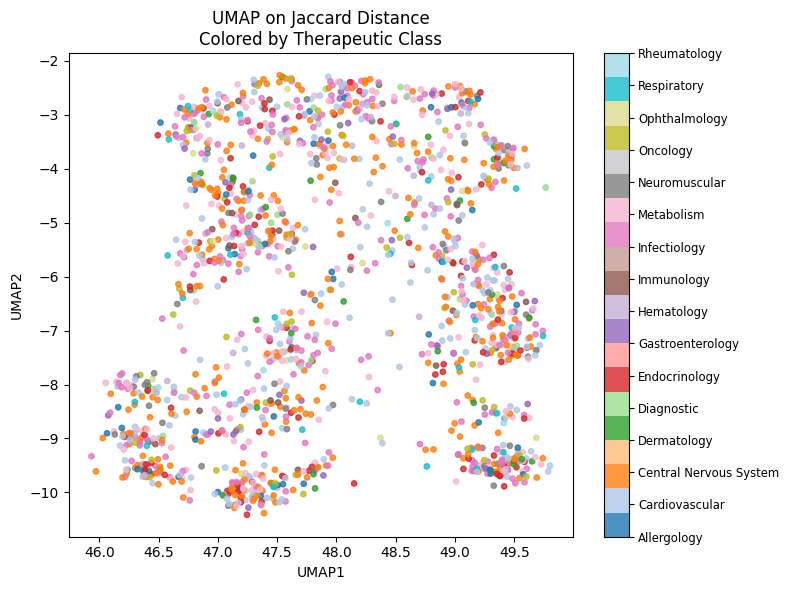

In [11]:
n_clusters = len(valid_classes)
sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
cluster_labels = sc.fit_predict(jaccard_sim)

reducer = umap.UMAP(n_components=2, metric='precomputed', random_state=42)
embedding = reducer.fit_transform(jaccard_dist)

info = drug_info_df_filtered.set_index('Drug Name')
classes = sorted(info['Therapeutic class'].unique())
class_to_idx = {cls: i for i, cls in enumerate(classes)}
colors = [class_to_idx[info.loc[d,'Therapeutic class']] for d in drug_list_cl]

plt.figure(figsize=(8,6))
plt.scatter(embedding[:,0], embedding[:,1], c=colors,
            cmap='tab20', s=15, alpha=0.8)
cbar = plt.colorbar(ticks=range(len(classes)))
cbar.ax.set_yticklabels(classes, fontsize='small')
plt.title('UMAP on Jaccard Distance\nColored by Therapeutic Class')
plt.xlabel('UMAP1'); plt.ylabel('UMAP2')
plt.tight_layout()
plt.show()

In [12]:
df = pd.DataFrame({
    'drug':      drug_list_cl,
    'cluster':   cluster_labels,
    'class':     [info.loc[d,'Therapeutic class'] for d in drug_list_cl],
    'MoA':       [info.loc[d,'drug mode of action annotation'] or 'Unknown'
                  for d in drug_list_cl]
})

ct_class = pd.crosstab(df['cluster'], df['class'])
ct_class_norm = ct_class.div(ct_class.sum(axis=1), axis=0)

class_assoc = ct_class_norm.corr()
link_class = sch.linkage(1 - class_assoc, method='average')
dendro_class = sch.dendrogram(link_class, labels=class_assoc.columns, no_plot=True)
class_order = dendro_class['ivl']

/tmp/ipykernel_960416/3212445245.py:13: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link_class = sch.linkage(1 - class_assoc, method='average')


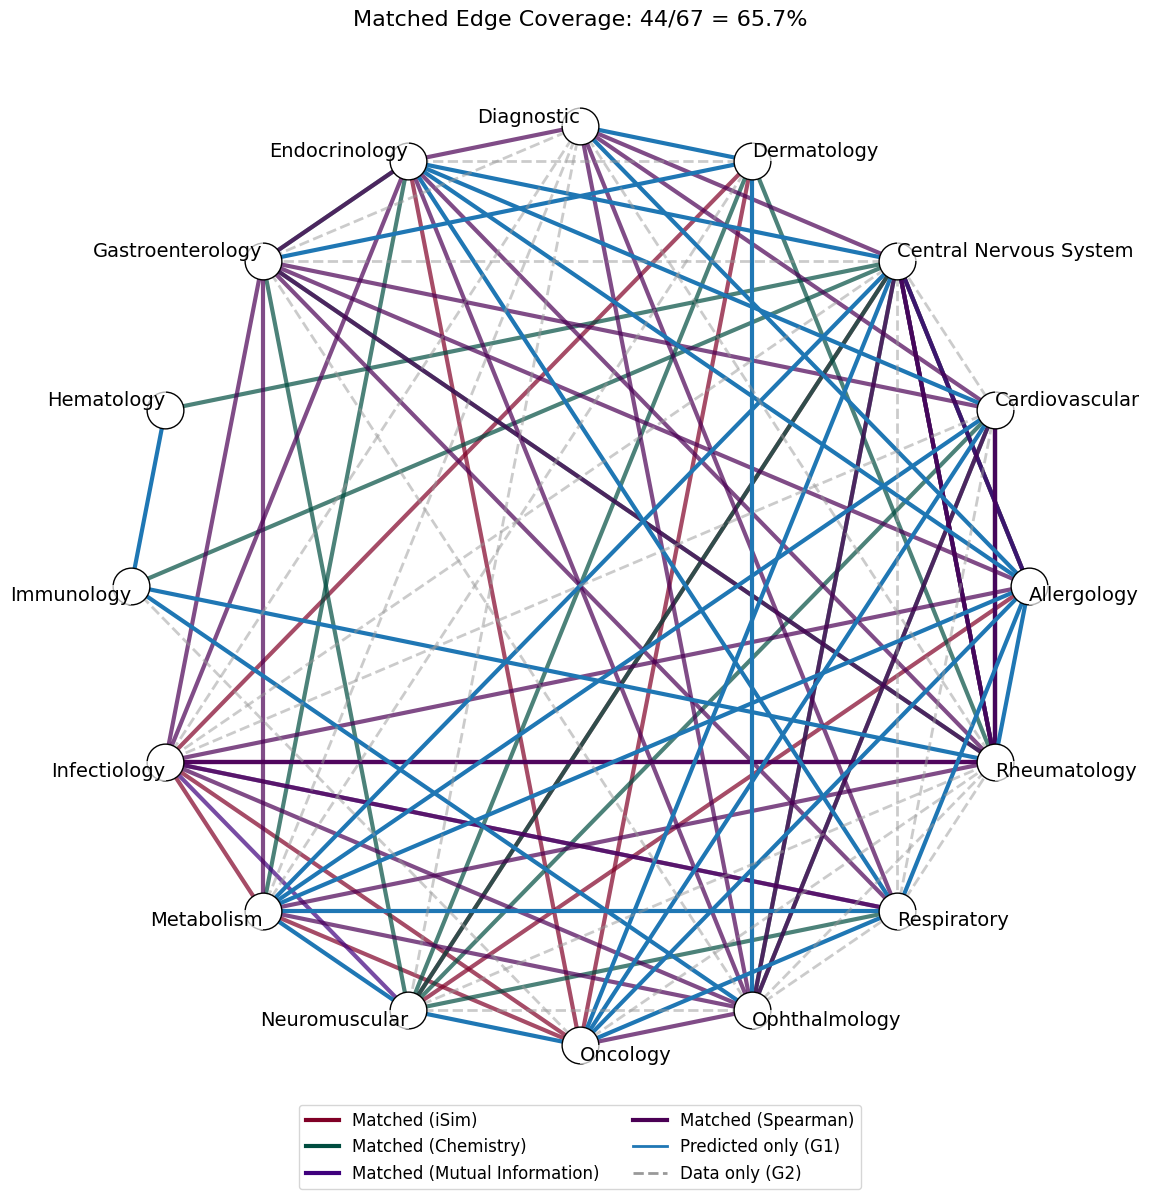

In [13]:
color_pred_only = "#1f77b4"  
color_data_only = "#999999"  
color_map = {
    'iSim': "#800026",               
    'Chemistry': "#004d40",          
    'Mutual Information': "#3f007d", 
    'Spearman': "#4b0055"            
}
thresholds = {
    'iSim': 0.2,
    'Chemistry': 0.7,
    'Mutual Information': 0.2,
    'Spearman': 0.2
}


def build_combined_network(class_assoc, edge_dict, G1_thres=0.3):
    G = nx.Graph()
    classes_all = class_assoc.index.tolist()
    for cls in classes_all:
        G.add_node(cls)

    for i, c1 in enumerate(classes_all):
        for j, c2 in enumerate(classes_all):
            if j <= i or c1 == c2: continue
            weight = class_assoc.loc[c1, c2]
            if abs(weight) > G1_thres:
                G.add_edge(c1, c2, weight=weight, pred=True)

    edge_sources = {}
    for name, df in edge_dict.items():
        threshold = thresholds[name]
        for _, row in df.iterrows():
            a, b = row['class1'], row['class2']
            if a == b or row['adj_p'] >= 0.05: continue
            edge = tuple(sorted((a, b)))
            edge_sources.setdefault(edge, set()).add(name)

    for edge, sources in edge_sources.items():
        a, b = edge
        if G.has_edge(a, b):
            G[a][b]['data_sig'] = True
            G[a][b]['source_set'] = sources
        else:
            G.add_edge(a, b, weight=0.15, pred=False, data_sig=True, dashed=True, source_set=sources)

    return G, edge_sources

def draw_combined_network(G, edge_sources, class_assoc, G1_thres=0.3):
    pos = nx.circular_layout(G)
    fig, ax = plt.subplots(figsize=(12, 12))

    pred_only_edges = []
    data_only_edges = []
    matched_by_source = {k: [] for k in color_map}

    for u, v, d in G.edges(data=True):
        if u == v: continue
        if d.get('pred') and d.get('data_sig'):
            for src in d.get('source_set', []):
                matched_by_source[src].append((u, v))
        elif d.get('pred'):
            pred_only_edges.append((u, v))
        elif d.get('data_sig') and d.get('dashed', False):
            data_only_edges.append((u, v))

    nx.draw_networkx_nodes(G, pos, ax=ax, node_color='white', edgecolors='black', node_size=700)

    for name, edges in matched_by_source.items():
        nx.draw_networkx_edges(G, pos, edgelist=edges, ax=ax, width=3,
                               edge_color=color_map[name], style='solid', label=f"Matched ({name})", alpha=0.7)

    nx.draw_networkx_edges(G, pos, edgelist=pred_only_edges, ax=ax, width=3,
                           edge_color=color_pred_only, style='solid', label='Predicted only (G1)')

    nx.draw_networkx_edges(G, pos, edgelist=data_only_edges, ax=ax, width=2,
                           edge_color=color_data_only, style='dashed', label='Data only (G2)', alpha=0.5)

    for node, (x, y) in pos.items():
        ha = 'left' if x >= 0 else 'right'
        va = 'bottom' if y >= 0 else 'top'
        ax.text(x, y, node, fontsize=14, ha=ha, va=va,
                bbox=dict(facecolor='white', edgecolor='none', pad=0.2, alpha=0.7),
                clip_on=False, zorder=10)

    total_matched = sum(1 for u, v, d in G.edges(data=True) if d.get('pred') and d.get('data_sig'))
    total_G1 = sum(
        1 for i in range(len(class_assoc)) for j in range(i+1, len(class_assoc))
        if abs(class_assoc.iloc[i, j]) > G1_thres
    )
    coverage = total_matched / total_G1 if total_G1 > 0 else 0

    ax.set_title(f"Matched Edge Coverage: {total_matched}/{total_G1} = {coverage:.1%}", fontsize=16, pad=-20)
    ax.axis('off')

    handles = [plt.Line2D([0], [0], color=color_map[k], lw=3, label=f'Matched ({k})') for k in color_map] + [
        plt.Line2D([0], [0], color=color_pred_only, lw=2, label='Predicted only (G1)'),
        plt.Line2D([0], [0], color=color_data_only, lw=2, linestyle='--', label='Data only (G2)')
    ]
    ax.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize=12)

    plt.tight_layout()
    #plt.savefig(f"../results/model_3/consistent_network.png", dpi=500)
    plt.show()

edge_dict = {
    'iSim': get_hypergeom_edges(drug_sim_df, threshold=0.2),
    'Chemistry': get_hypergeom_edges(drug_sim_ch_df, threshold=0.7),
    'Mutual Information': get_hypergeom_edges(drug_sim_MI_df.abs(), threshold=0.2),
    'Spearman': get_hypergeom_edges(drug_sim_sp_df.abs(), threshold=0.2)
}

G, edge_sources = build_combined_network(class_assoc, edge_dict, G1_thres=0.2)
draw_combined_network(G, edge_sources, class_assoc, G1_thres=0.2)

In [4]:
#Sankey diagram of the three-layer regulatory landscape and heatmap
uniprot_df = pd.read_csv('../data/uniprotkb_AND_model_organism_9606_2024_08_12.tsv', sep='\t')
NCBI_df = pd.read_csv('../data/ncbi_dataset.tsv', sep='\t')
Symbol_uniport_dict = NCBI_df.set_index('Symbol')['SwissProt Accessions'].to_dict()
entry_kegg_dict = uniprot_df[~uniprot_df['KEGG'].isna()].set_index('Entry').to_dict()['KEGG']
entry_kegg_dict ={k:v.split(';')[:-1] for k,v in entry_kegg_dict.items()}
Symbol_kegg_dict = {k:entry_kegg_dict[v] for k,v in Symbol_uniport_dict.items() if v in entry_kegg_dict}
kegg_p_dict = {}
with open('../data/pathway_gene_mapping.txt') as f:
    for line in f:
        line = line.strip()
        pathway = line.split('\t')[0][5:]
        gene = line.split('\t')[1]
        if pathway not in kegg_p_dict:
            kegg_p_dict[pathway] = []
        kegg_p_dict[pathway].append(gene)
kegg_info_dict = {}
with open('../data/pathway_information.txt') as f:
    for line in f:
        line = line.strip()
        if line.split('\t')[3] != 'Human Diseases':
            kegg_info_dict[line.split('\t')[0]] = [line.split('\t')[1], line.split('\t')[2]]
gene_pathway_dict = {}
for pathway, gene_list in kegg_p_dict.items():
    if pathway in kegg_info_dict:
        for gene in gene_list:
            if gene not in gene_pathway_dict:
                gene_pathway_dict[gene] = []
            gene_pathway_dict[gene].append([kegg_info_dict[pathway][0],kegg_info_dict[pathway][1]])
Symbol_pathway_dict = {}
for gene, kegg_id_list in Symbol_kegg_dict.items():
        tmp_l = []
        for kegg_id in kegg_id_list:
            if kegg_id in gene_pathway_dict:
                for k in gene_pathway_dict[kegg_id]:
                    pathway_l = k[0]
                    tmp_l.append(pathway_l)
        Symbol_pathway_dict[gene] = list(set(tmp_l))
Symbol_pathway_dict_d = {}
for gene, kegg_id_list in Symbol_kegg_dict.items():
        tmp_l = []
        for kegg_id in kegg_id_list:
            if kegg_id in gene_pathway_dict:
                for k in gene_pathway_dict[kegg_id]:
                    pathway_l = k[1]
                    tmp_l.append(pathway_l)
        Symbol_pathway_dict_d[gene] = list(set(tmp_l))
with open('../data/hmdb_id.json') as f:
    hmdb_dict = json.load(f)
hmdb_name_dict = {}
for hmid, ann_dict in hmdb_dict.items():
    hmdb_name_dict[hmid] = ann_dict['name']
kegg_hmdb_dict = {}
for hmdb_id, ann_dict in hmdb_dict.items():
    if ('kegg_id' in ann_dict) and (ann_dict['kegg_id'] != ''):
        kegg_hmdb_dict[ann_dict['kegg_id']] = hmdb_id
uniprot_symbol_dict = {v:k for k,v in Symbol_uniport_dict.items()}
hmdb_reverse_dict = {v:k for k,v in hmdb_name_dict.items()}
hmdb_kegg_dict =  {}
for k_id, hm_id in kegg_hmdb_dict.items():
    if hm_id not in hmdb_kegg_dict:
        hmdb_kegg_dict[hm_id] = []
    hmdb_kegg_dict[hm_id].append(k_id)
kegg_m_dict = {}
with open('../data/pathway_meta_mapping.txt') as f:
    for line in f:
        line = line.strip()
        pathway = 'hsa' + line.split('\t')[1][8:]
        meta = line.split('\t')[0][4:]
        if pathway not in kegg_m_dict:
            kegg_m_dict[pathway] = []
        kegg_m_dict[pathway].append(meta)
kegg_m_r_dict = {}
for pathway, kegg_list in kegg_m_dict.items():
    for kegg_id in kegg_list:
        if kegg_id not in kegg_m_r_dict:
            kegg_m_r_dict[kegg_id] = []
        kegg_m_r_dict[kegg_id].append(pathway)
hmdb_pathway_dict = {}
for hmdb_id, kegg_list in hmdb_kegg_dict.items():
    kegg_list_ex = [kegg for kegg in kegg_list if kegg in kegg_m_r_dict]
    hmdb_pathway_dict[hmdb_id] = list(set([kegg_info_dict[pathway][0] for kegg in kegg_list_ex for pathway in kegg_m_r_dict[kegg] if pathway in kegg_info_dict]))
Symbol_pathway_dict_d = {}
for gene, kegg_id_list in Symbol_kegg_dict.items():
    tmp_l = []
    for kegg_id in kegg_id_list:
        if kegg_id in gene_pathway_dict:
            for k in gene_pathway_dict[kegg_id]:
                if k[1] == ' Signaling molecules and interaction':
                    tmp_l.append(k[0])
                else:
                    tmp_l.append(k[1].lstrip())
    Symbol_pathway_dict_d[gene] = list(set(tmp_l))
kegg_info_df = pd.read_csv('../data/pathway_information.txt', sep='\t')

/tmp/ipykernel_1963010/3726122204.py:2: DtypeWarning: Columns (9,11,12,16) have mixed types. Specify dtype option on import or set low_memory=False.
  uniprot_df = pd.read_csv('../data/uniprotkb_AND_model_organism_9606_2024_08_12.tsv', sep='\t')
/tmp/ipykernel_1963010/3726122204.py:3: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  NCBI_df = pd.read_csv('../data/ncbi_dataset.tsv', sep='\t')


In [6]:
drug_class_dict = drug_info_df_filtered.set_index('Drug Name').to_dict()['Therapeutic class']
meta_class_dict = meta_type_df.set_index('HMDB_ID').to_dict()['Class']
meta_subclass_dict = meta_type_df.set_index('HMDB_ID').to_dict()['Subclass']

pred_top_ex_df = pred_top_df[pred_top_df['protein_id'].isin(Symbol_pathway_dict_d)]
pred_top_ex_df = pred_top_ex_df[pred_top_ex_df['metabolite_id'].isin(meta_class_dict)]

pred_top_ex_df ['drug_class'] = pred_top_ex_df ['drug'].apply(lambda x:drug_class_dict[x])
pred_top_ex_df ['metabolite_class'] = pred_top_ex_df ['metabolite_id'].apply(lambda x:meta_class_dict[x])
pred_top_ex_df ['metabolite_subclass'] = pred_top_ex_df ['metabolite_id'].apply(lambda x:meta_subclass_dict[x])
pred_top_ex_df ['protein_class_d'] = pred_top_ex_df ['protein_id'].apply(lambda x:Symbol_pathway_dict[x])
pred_top_ex_df ['protein_class'] = pred_top_ex_df ['protein_id'].apply(lambda x:Symbol_pathway_dict_d[x])
print(len(pred_top_ex_df['protein_id'].unique()), len(pred_top_ex_df['metabolite_id'].unique()), len(pred_top_ex_df['drug'].unique()))
print(len(pred_top_df['protein_id'].unique()), len(pred_top_df['metabolite_id'].unique()), len(pred_top_df['drug'].unique()))

10268 1876 1358
10653 1876 1503


In [14]:
df = pred_top_ex_df.copy()
df = pred_top_ex_df.explode("protein_class").dropna(subset=["drug_class", "protein_class", "metabolite_subclass"])
N = len(df)

cmap = get_cmap('tab20')  
all_colors = [mcolors.to_hex(cmap(i / 20)) for i in range(20)]

dp = df.groupby(["drug_class", "protein_class"]).size().reset_index(name="count")
drug_tot = df["drug_class"].value_counts().to_dict()
prot_tot = df["protein_class"].value_counts().to_dict()
dp["K"] = dp["protein_class"].map(prot_tot)
dp["n"] = dp["drug_class"].map(drug_tot)
dp["pval"] = dp.apply(lambda r: hypergeom.sf(r["count"]-1, N, r["K"], r["n"]), axis=1)

pm = df.groupby(["protein_class", "metabolite_subclass"]).size().reset_index(name="count")
met_tot = df["metabolite_subclass"].value_counts().to_dict()
pm["K"] = pm["metabolite_subclass"].map(met_tot)
pm["n"] = pm["protein_class"].map(prot_tot)
pm["pval"] = pm.apply(lambda r: hypergeom.sf(r["count"]-1, N, r["K"], r["n"]), axis=1)

flow = df.groupby(["drug_class", "protein_class", "metabolite_subclass"]).size().reset_index(name="count")
flow = flow[flow["count"] / N >= 0.0008].copy()
sig_dp = set(tuple(x) for x in dp[dp["pval"] < 1][["drug_class", "protein_class"]].values)
sig_pm = set(tuple(x) for x in pm[pm["pval"] < 1][["protein_class", "metabolite_subclass"]].values)

flow = flow[flow.apply(lambda r: (r["drug_class"], r["protein_class"]) in sig_dp or
                                  (r["protein_class"], r["metabolite_subclass"]) in sig_pm, axis=1)]
total_flow = flow["count"].sum()
node_weights = pd.concat([
    flow.groupby("drug_class")["count"].sum(),
    flow.groupby("protein_class")["count"].sum(),
    flow.groupby("metabolite_subclass")["count"].sum()
])

labels_map = {
    k: f"{k} ({v/total_flow:.1%})" for k, v in node_weights.items()
}

drug_order = flow.groupby("drug_class")["count"].sum().sort_values(ascending=False).index.tolist()
protein_order = flow.groupby("protein_class")["count"].sum().sort_values(ascending=False).index.tolist()
metabolite_order = flow.groupby("metabolite_subclass")["count"].sum().sort_values(ascending=False).index.tolist()

flow["drug_label"] = flow["drug_class"].map(labels_map)
flow["protein_label"] = flow["protein_class"].map(labels_map)
flow["metabolite_label"] = flow["metabolite_subclass"].map(labels_map)

flow = flow.sort_values(["drug_class", "protein_class", "metabolite_subclass"])

/tmp/ipykernel_1963010/3892708609.py:5: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



In [16]:
flow_d = df.groupby(["drug_class", "protein_class", "metabolite_subclass"]).size().reset_index(name="count")
flow_d = flow_d[flow_d["count"] / N >= 0.0005].copy()
sig_dp = set(tuple(x) for x in dp[dp["pval"] < 0.01][["drug_class", "protein_class"]].values)
sig_pm = set(tuple(x) for x in pm[pm["pval"] < 0.01][["protein_class", "metabolite_subclass"]].values)

flow_d = flow_d[flow_d.apply(lambda r: (r["drug_class"], r["protein_class"]) in sig_dp or
                                  (r["protein_class"], r["metabolite_subclass"]) in sig_pm, axis=1)]
total_flow_d = flow_d["count"].sum()
node_weights = pd.concat([
    flow_d.groupby("drug_class")["count"].sum(),
    flow_d.groupby("protein_class")["count"].sum(),
    flow_d.groupby("metabolite_subclass")["count"].sum()
])

labels_map = {
    k: f"{k} ({v/total_flow_d:.1%})" for k, v in node_weights.items()
}

drug_order = flow_d.groupby("drug_class")["count"].sum().sort_values(ascending=False).index.tolist()
protein_order = flow_d.groupby("protein_class")["count"].sum().sort_values(ascending=False).index.tolist()
metabolite_order = flow_d.groupby("metabolite_subclass")["count"].sum().sort_values(ascending=False).index.tolist()

flow_d["drug_label"] = flow_d["drug_class"].map(labels_map)
flow_d["protein_label"] = flow_d["protein_class"].map(labels_map)
flow_d["metabolite_label"] = flow_d["metabolite_subclass"].map(labels_map)

flow_d = flow_d.sort_values(["drug_class", "protein_class", "metabolite_subclass"])

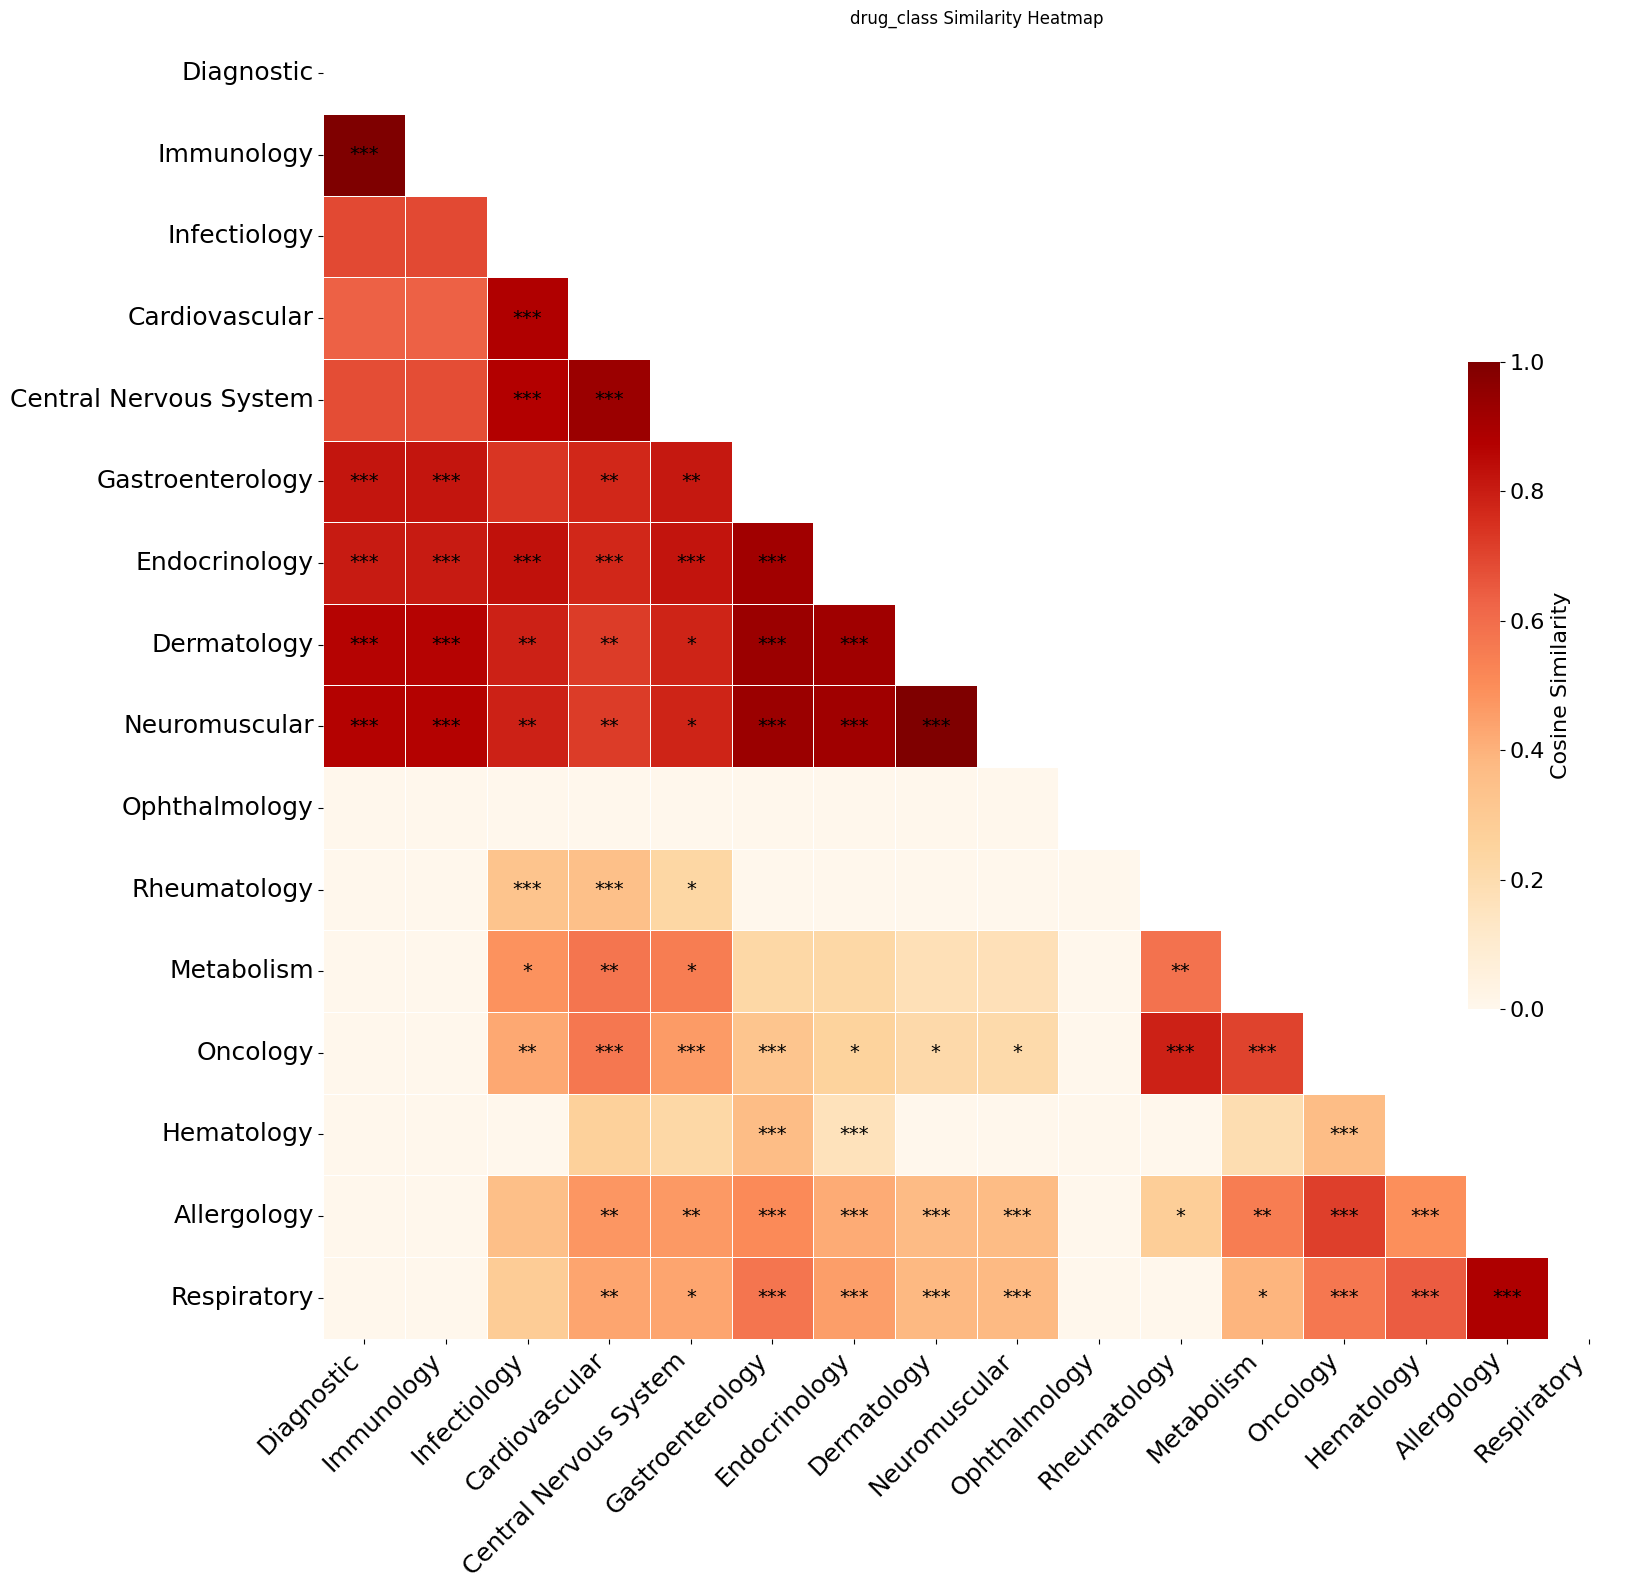

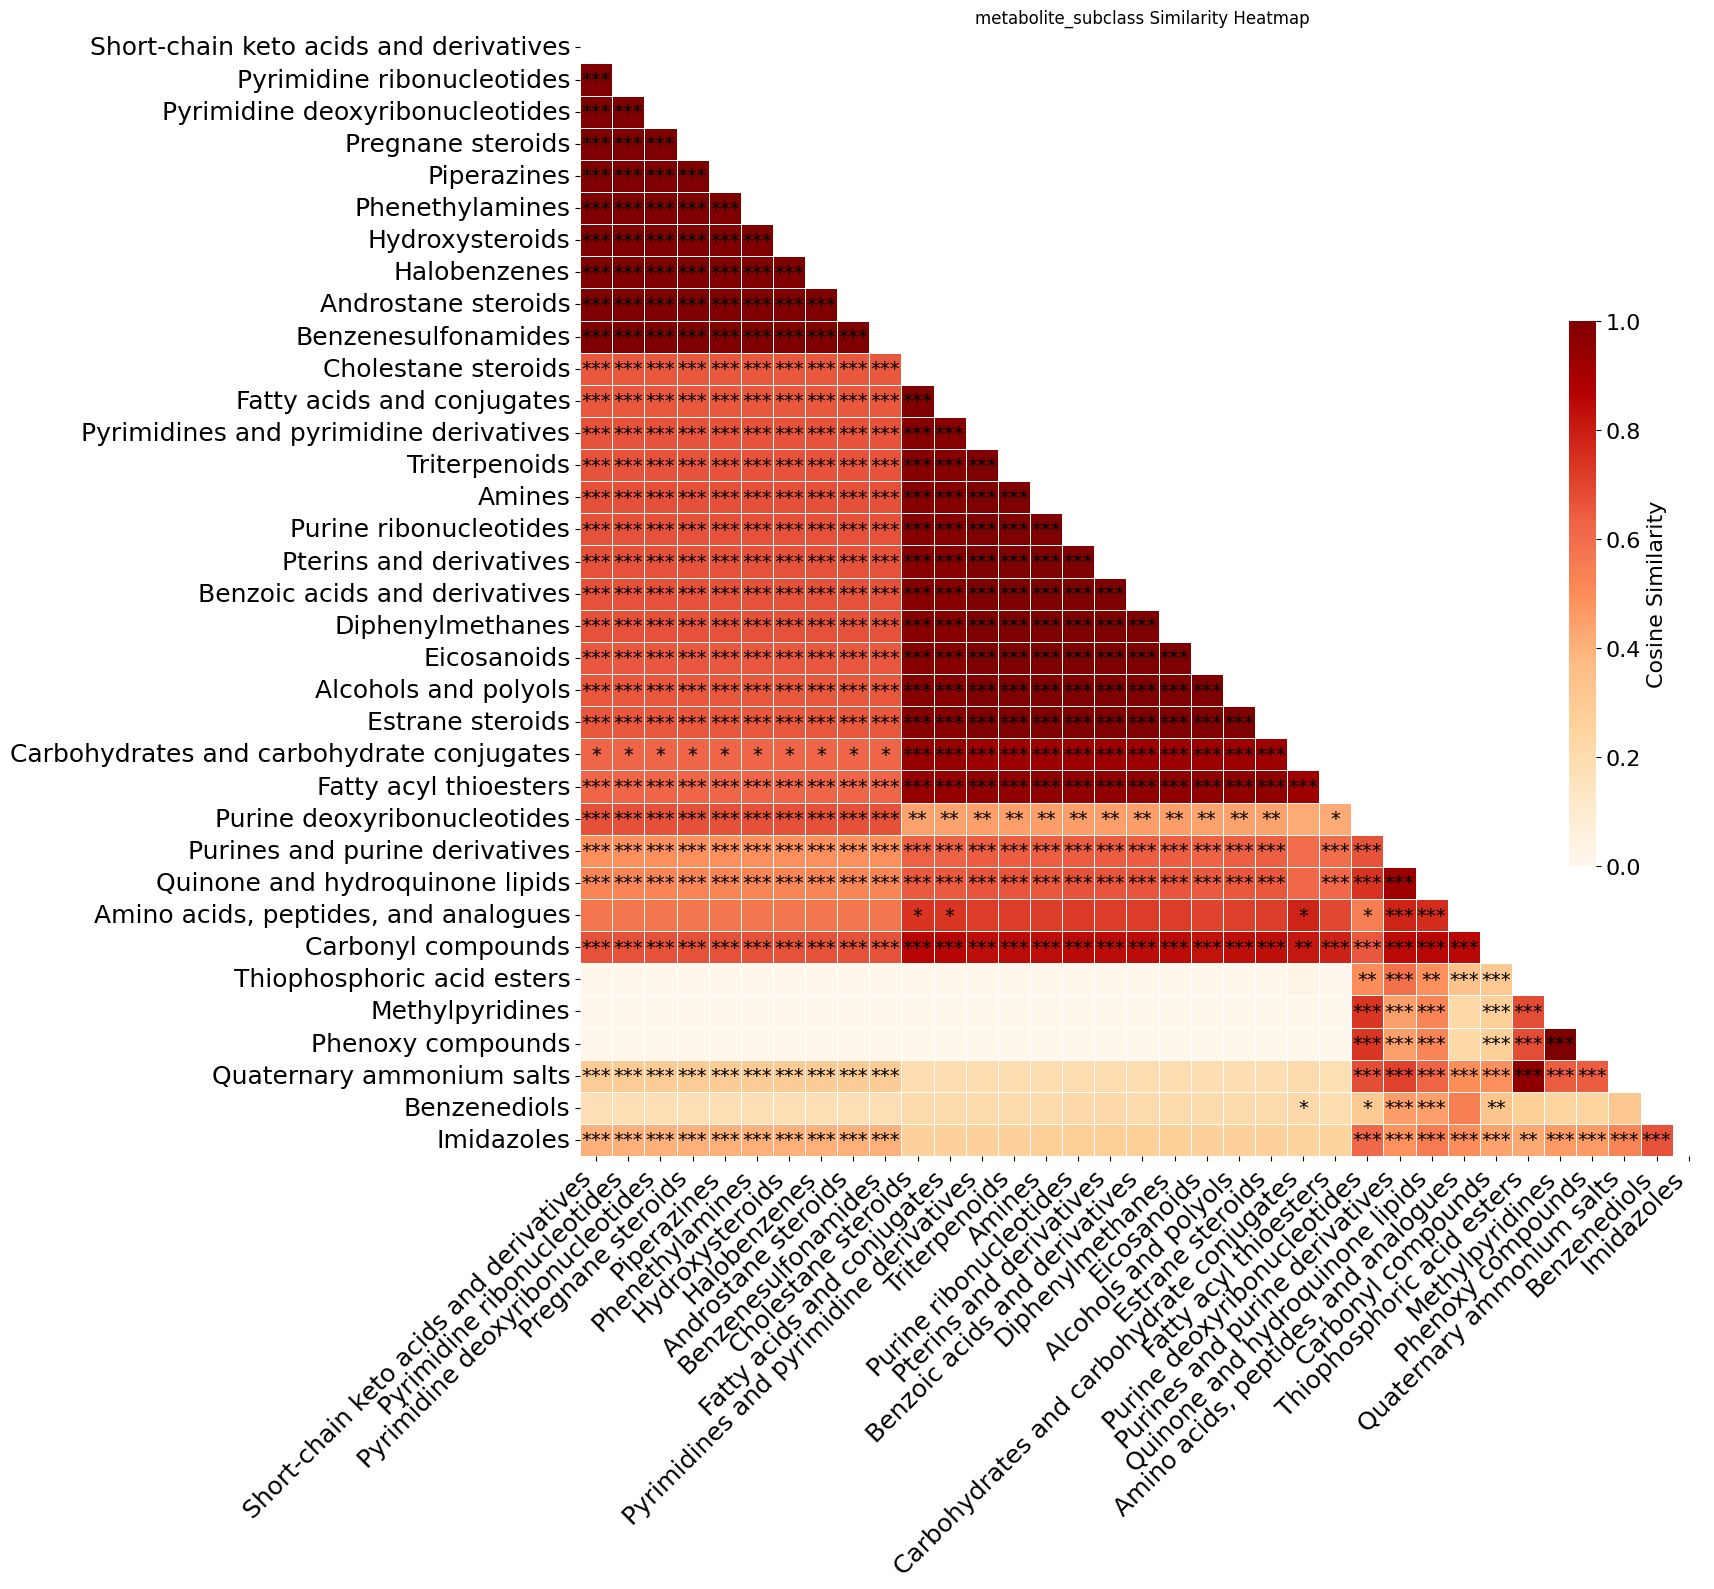

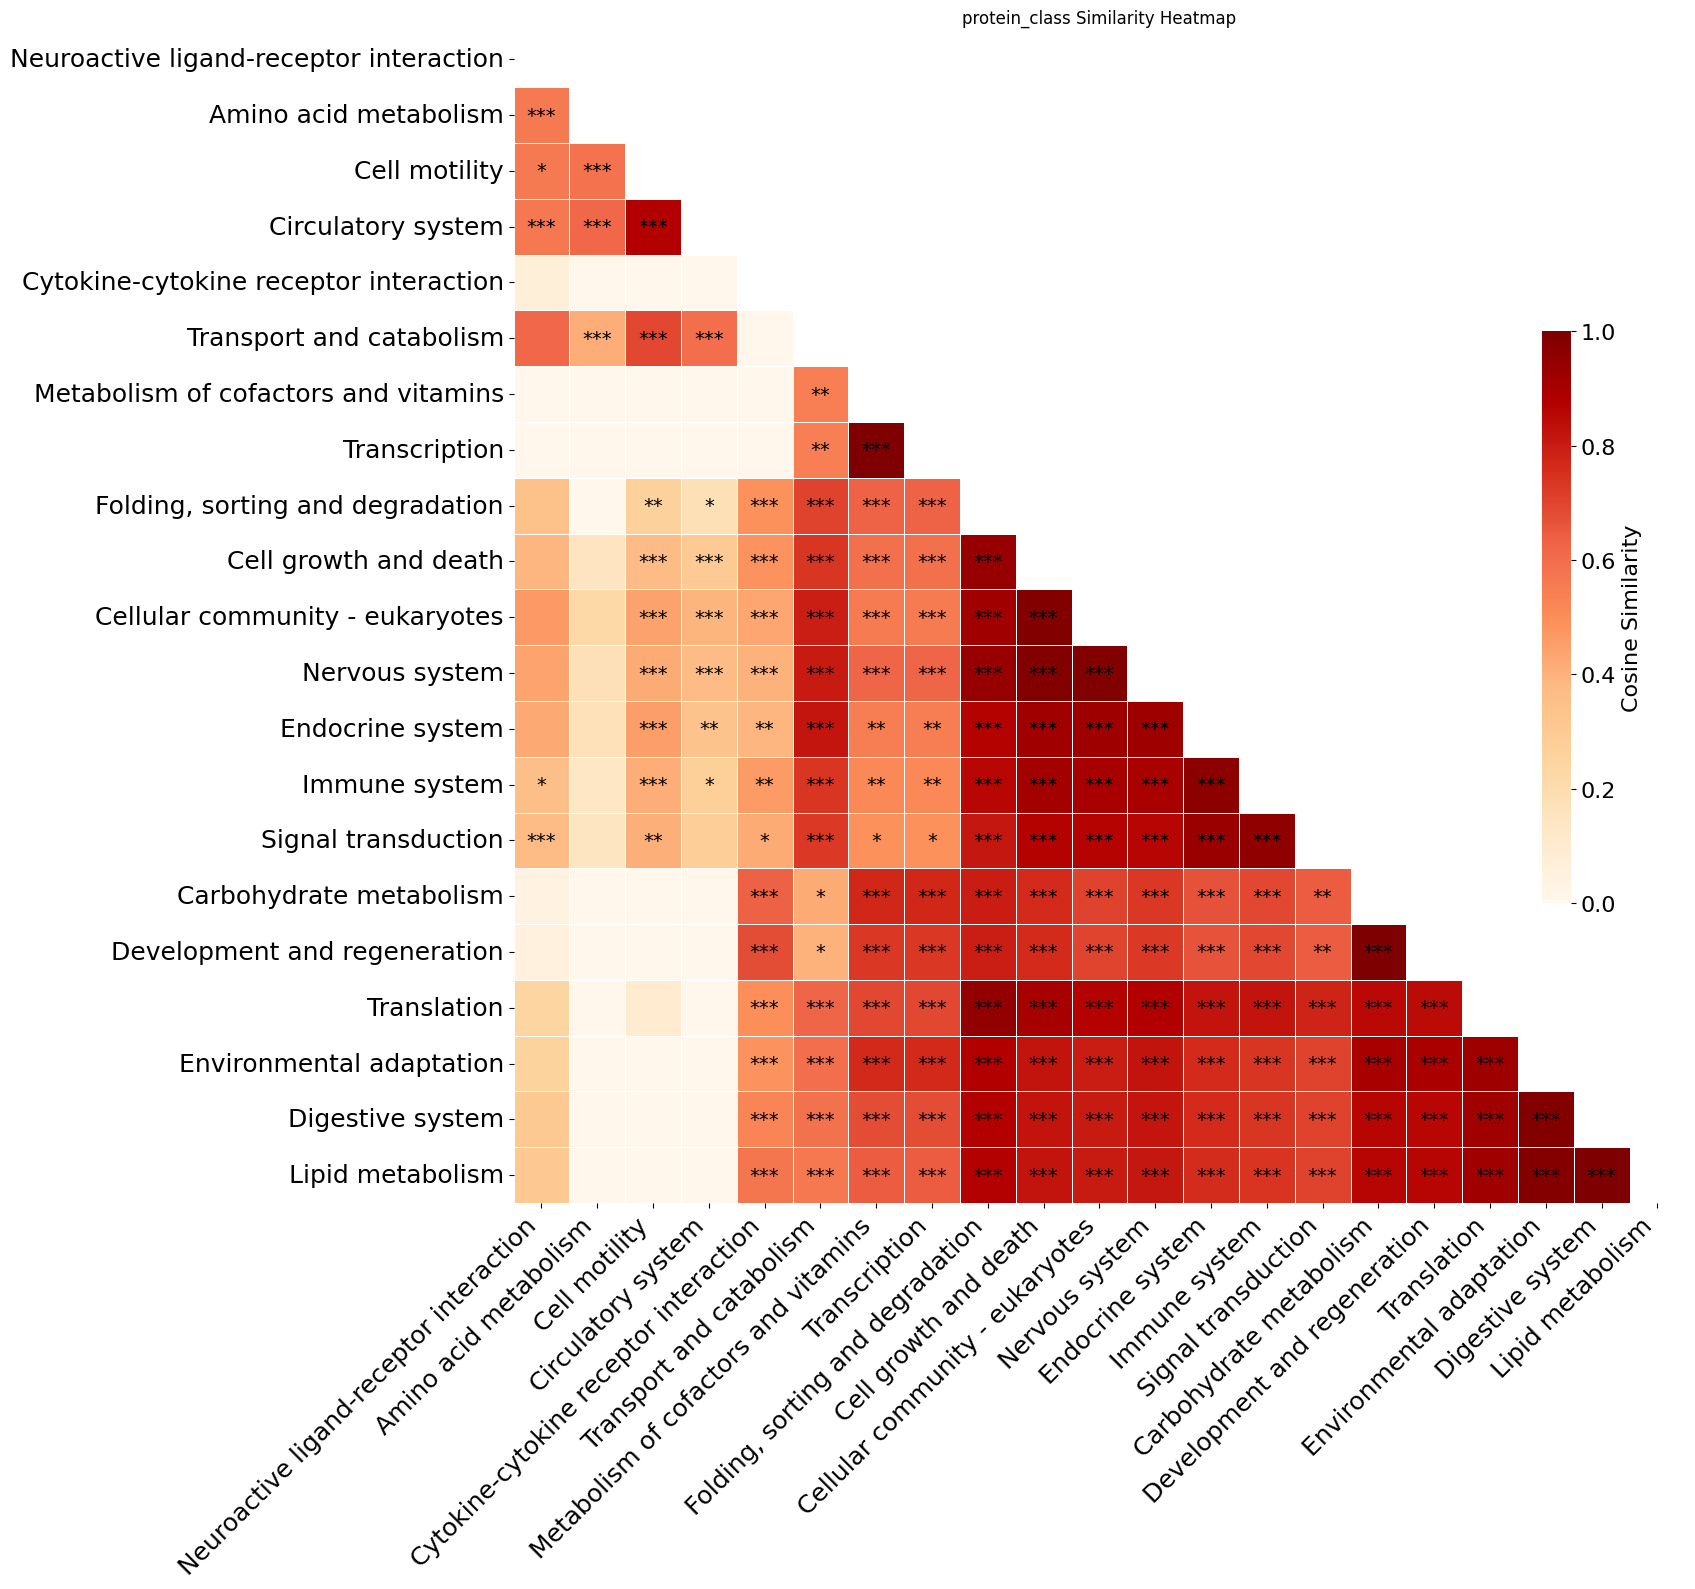

In [19]:
def build_similarity_halfheatmap(entity_col, other_cols, flow):
    pivot = flow.pivot_table(index=entity_col, columns=other_cols, values='count', fill_value=0)
    matrix = pivot.values
    labels = pivot.index.tolist()
    
    sim = cosine_similarity(matrix)
    sim_df = pd.DataFrame(sim, index=labels, columns=labels)
    
    dist = pdist(sim)
    linkage_matrix = linkage(dist, method='average')
    order = leaves_list(linkage_matrix)
    ordered_labels = [labels[i] for i in order]
    sim_df = sim_df.loc[ordered_labels, ordered_labels]
    
    pval_matrix = np.zeros_like(sim)
    for i in range(len(labels)):
        for j in range(len(labels)):
            if i < j:
                r, p = spearmanr(matrix[i], matrix[j])
                pval_matrix[i, j] = pval_matrix[j, i] = p
            elif i == j:
                pval_matrix[i, j] = 0
    pval_df = pd.DataFrame(pval_matrix, index=labels, columns=labels)
    pval_df = pval_df.loc[ordered_labels, ordered_labels]
    
    mask = np.triu(np.ones_like(sim_df, dtype=bool))
    
    plt.figure(figsize=(18,16))
    ax = sns.heatmap(sim_df, mask=mask, cmap='OrRd', cbar_kws={'label':'Cosine Similarity','fraction': 0.02,'pad': -0.1},
                     annot=False, linewidths=0.5, square=True, vmin=0, vmax=1)
            
    
    for i in range(len(ordered_labels)):
        for j in range(len(ordered_labels)):
            if i > j:
                p = pval_df.iloc[i,j]
                star = ''
                if p < 0.001: star = '***'
                elif p < 0.01: star = '**'
                elif p < 0.05: star = '*'
                if star:
                    ax.text(j+0.5, i+0.5, star, ha='center', va='center', color='black', fontsize=14)
    
    ax.set_title(f'{entity_col} Similarity Heatmap')
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=16)
    cbar.set_label("Cosine Similarity", fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=18)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
    plt.tight_layout()
    #plt.savefig(f"flow_sim_{entity_col}.png", dpi=500)
    plt.show()

build_similarity_halfheatmap('drug_class', ['metabolite_subclass', 'protein_class'], flow_d)
build_similarity_halfheatmap('metabolite_subclass', ['drug_class', 'protein_class'], flow_d)
build_similarity_halfheatmap('protein_class', ['drug_class', 'metabolite_subclass'], flow_d)

In [33]:
FIG_WIDTH  = 3200
FIG_HEIGHT = 1600
NODE_THICKNESS = 30
NODE_PAD       = 18
COLUMN_POSITIONS = (0.00, 0.55, 1.00)
COLUMN_SPAN_RATIO = 0.82
FONT_SIZE  = 35
FONT_COLOR = "black"

GRAY    = "#B8B8B8"
THRESH  = 0.02   # < 阈值置灰

BASE_PALETTE = [
    "#0072B2", "#E69F00", "#009E73", "#CC79A7", "#56B4E9", "#D55E00", "#6A5ACD", "#8DD3C7",
    "#B3B3B3", "#80B1D3", "#FDB462", "#B3DE69", "#BC80BD", "#CCEBC5", "#FF7F00", "#1F78B4",
    "#A6CEE3", "#FB9A99", "#CAB2D6", "#FDBF6F", "#B2DF8A", "#33A02C", "#A1C9F4", "#FFB482"
]

def lighten(hex_color, factor=0.05):
    c = mcolors.to_rgb(hex_color)
    white = (1, 1, 1)
    mixed = tuple((1-factor)*c[i] + factor*white[i] for i in range(3))
    return mcolors.to_hex(mixed)

def build_palette(n):
    colors = []
    colors.extend(BASE_PALETTE[:min(n, len(BASE_PALETTE))])
    if len(colors) < n:
        for c in BASE_PALETTE:
            colors.append(lighten(c, 0.5))
            if len(colors) >= n:
                break
    if len(colors) < n:
        cmap = get_cmap("tab20")
        k = n - len(colors)
        extra = [mcolors.to_hex(cmap(i/20)) for i in range(k)]
        extra = [lighten(c, 0.4) for c in extra]
        colors.extend(extra)
    return colors[:n]

def rgba_from_hex(hex_color, alpha=0.95):
    r, g, b = mcolors.to_rgb(hex_color)
    return f"rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, {alpha})"

flow_for_plot = flow[["drug_label","protein_label","metabolite_label","count"]].copy()
flow_for_plot = flow_for_plot.rename(columns={
    "drug_label": "drug",
    "protein_label": "protein",
    "metabolite_label": "metabolite",
    "count": "value"
})

dp = flow_for_plot.groupby(["drug","protein"], as_index=False)["value"].sum()
pm = flow_for_plot.groupby(["protein","metabolite"], as_index=False)["value"].sum()

drug_names       = sorted(dp["drug"].unique().tolist())
protein_names    = sorted(list(set(dp["protein"]).union(pm["protein"])))
metabolite_names = sorted(pm["metabolite"].unique().tolist())

node_throughput = {n: 0.0 for n in (drug_names + protein_names + metabolite_names)}

drug_tot = dp.groupby("drug")["value"].sum().to_dict()
for k, v in drug_tot.items(): node_throughput[k] += float(v)

prot_in  = dp.groupby("protein")["value"].sum().to_dict()
prot_out = pm.groupby("protein")["value"].sum().to_dict()
for k in protein_names:
    node_throughput[k] += float(prot_in.get(k, 0.0) + prot_out.get(k, 0.0))

meta_tot = pm.groupby("metabolite")["value"].sum().to_dict()
for k,v in meta_tot.items(): node_throughput[k] += float(v)

drug_den = sum(drug_tot.values()) or 1.0
prot_den = sum((prot_in.get(k,0.0)+prot_out.get(k,0.0)) for k in protein_names) or 1.0
meta_den = sum(meta_tot.values()) or 1.0

def node_ratio(name: str) -> float:
    if name in drug_names:
        return node_throughput[name] / drug_den
    if name in protein_names:
        return node_throughput[name] / prot_den
    return node_throughput[name] / meta_den

drug_nodes       = sorted(drug_names,       key=node_ratio, reverse=True)
protein_nodes    = sorted(protein_names,    key=node_ratio, reverse=True)
metabolite_nodes = sorted(metabolite_names, key=node_ratio, reverse=True)

drug_palette       = build_palette(len(drug_nodes))
protein_palette    = build_palette(len(protein_nodes))
metabolite_palette = build_palette(len(metabolite_nodes))

def assign_colors(nodes, palette, ratio_func):
    colors = []
    for i, node in enumerate(nodes):
        if ratio_func(node) < THRESH:
            colors.append(GRAY)
        else:
            base = palette[i % len(palette)]
            colors.append(lighten(base, 0.6))  
    return colors

drug_colors       = assign_colors(drug_nodes,       drug_palette,       node_ratio)
protein_colors    = assign_colors(protein_nodes,    protein_palette,    node_ratio)
metabolite_colors = assign_colors(metabolite_nodes, metabolite_palette, node_ratio)
node_colors = drug_colors + protein_colors + metabolite_colors

drug_idx_map       = {n:i for i,n in enumerate(drug_nodes)}
protein_idx_map    = {n:i+len(drug_nodes) for i,n in enumerate(protein_nodes)}
metabolite_idx_map = {n:i+len(drug_nodes)+len(protein_nodes) for i,n in enumerate(metabolite_nodes)}

sources, targets, values, link_colors = [], [], [], []
for _, r in dp.iterrows():
    if r["drug"] in drug_idx_map and r["protein"] in protein_idx_map:
        s = drug_idx_map[r["drug"]]
        t = protein_idx_map[r["protein"]]
        sources.append(s); targets.append(t); values.append(float(r["value"]))
        link_colors.append(rgba_from_hex(node_colors[s], 0.55))

for _, r in pm.iterrows():
    if r["protein"] in protein_idx_map and r["metabolite"] in metabolite_idx_map:
        s = protein_idx_map[r["protein"]]
        t = metabolite_idx_map[r["metabolite"]]
        sources.append(s); targets.append(t); values.append(float(r["value"]))
        link_colors.append(rgba_from_hex(node_colors[s], 0.55))

labels = []
for node in drug_nodes + protein_nodes + metabolite_nodes:
    if node_ratio(node) < THRESH:
        labels.append("")  
    else:
        labels.append(node)


fig = go.Figure(data=[go.Sankey(
    arrangement="fixed",
    node=dict(
        pad=NODE_PAD,
        thickness=NODE_THICKNESS,
        line=dict(color="white", width=1),
        label=labels,
        color=node_colors,
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=[node_colors[src] for src in sources], 
        hovertemplate="flow: %{value}<extra></extra>"
    )
)])

fig.update_traces(selector=dict(type="sankey"),
                  textfont=dict(size=FONT_SIZE, color=FONT_COLOR, family="Arial Black"))

fig.update_layout(
    width=FIG_WIDTH, height=FIG_HEIGHT,
    margin=dict(l=20, r=20, t=20, b=20)
)

fig.show()
